In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Question 1

Given some sample data, write a program to answer the following:

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
What metric would you report for this dataset?
What is its value?


**Short Answer:** After implementing Outlier Detection with Isolation Forest, we can find that there are two issues with the data set: (1) shop with id number 78 has been entering order amount by missing the decimal point, which leads to order amounts looking like 100 times larger than usual. (2) shop with id number 42 has enormous order amounts that look like credit card fraud.

Once we solve these issues, AOV becomes $\$304.33$.

Alternatively, we could look at the median order value, $\$284$. This statistic is not prone to outliers. However, having a system that detects the outliers and warns the sneaker shops is beneficial for business growth. 

**Long Answer and Analysis:**

In [2]:
df = pd.read_csv("2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv")

Let's inspect the distribution of the numerical variables (order_amount and total_items) using summary statistics and exloratary visulizations. 

In [3]:
df[["total_items","order_amount"]].describe(percentiles=[0.05,0.5,0.95])

,total_items,order_amount
count,5000.00000,5000.000000
mean,8.78720,3145.128000
std,116.32032,41282.539349
min,1.00000,90.000000
5%,1.00000,122.000000
50%,2.00000,284.000000
95%,4.00000,640.000000
max,2000.00000,704000.000000


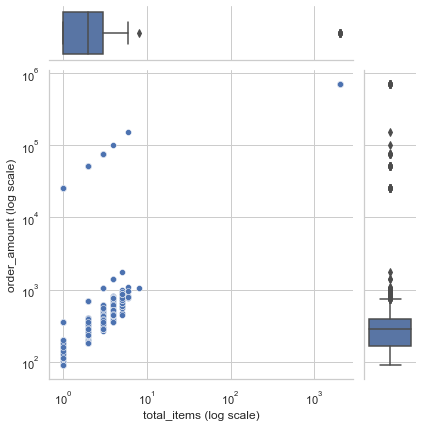

In [4]:
sns.set_style('whitegrid')
g = sns.JointGrid(x='total_items', y='order_amount',  data=df)
g.plot(sns.scatterplot,sns.boxplot)

g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
g.ax_joint.set_xlabel("total_items (log scale)")
g.ax_joint.set_ylabel("order_amount (log scale)")
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')

From the summary statistics, we can see that the naive measure for AOV was just the mean of order_amount. However, as we see from summary statistics and exloratary visulization, the distrubution of both order_amout and total_items have a long right tail, which leads to unrealisticly high AOV.

Let's identify "abnormal" or out-of-the-ordinary data points (outliers) and see if they are "technical glitches" that we can correct.

Since our data set possibly includes outliers, we will perform **outlier detection.**

In Scikit-learn, it is implemented as **unsupervised learning** methods. Common algorithms include **One-class SVM** and **Isolation Forests.** 

Isolation Forest (iForest) is a newer and more efficient method, especially for high-dimensional data sets.

Isolation Forest exploits two characteristics of anomalous observations: they are relatively few in number, and they are very different from "normal" values (Liu, Ting, and Zhou, 2008). An isolation forest aims to "isolate" the outliers based on these two facts, using an ensemble of classification trees.

### Isolation Forest in Scikit-learn

In [5]:
from sklearn.ensemble import IsolationForest

X = df[["total_items", "order_amount"]]
clf = IsolationForest(random_state=1001)
clf.fit(X)

y_pred = clf.predict(X)

float(sum(y_pred==-1))/len(y_pred) # proportion of outliers 

0.1304

This model labels $13\%$ of the observations as outliers. To understand why, it can help to look at the decision function. These scores are a non-linear function of the path-length metric and can take values between  −0.5  and  0.5. 

In [6]:
df["anomaly_score"] = clf.decision_function(X)

In [7]:
df["anomaly_score"].describe(percentiles=[0.01,0.5,0.99])

count    5000.000000
mean        0.067054
std         0.069118
min        -0.393137
1%         -0.266083
50%         0.092171
99%         0.120541
max         0.120541
Name: anomaly_score, dtype: float64

Higher values are less anomalous and lower values are more anomalous. This model is not perfect; some of the normal observations might be labeled as outliers. When working with low-dimensional data, plotting the decision function and decision boundary can give you a clear picture of what the model is doing.

Text(0, 0.5, 'order_amount (log scale)')

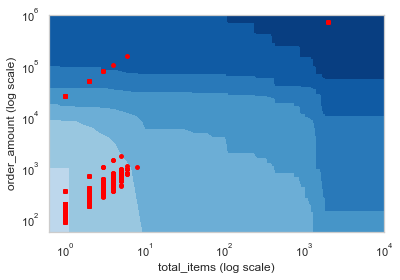

In [8]:
xx, yy = np.meshgrid(np.linspace(0, 10_000, 1_000), np.linspace(0, 1_000_000, 1_000))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 10), cmap=plt.cm.Blues_r)
plt.scatter(X["total_items"], X["order_amount"], s=15, c="red")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("total_items (log scale)")
plt.ylabel("order_amount (log scale)")

More anomalous observations consists of transactions with very large order amounts. Let's check such points to understand why it is the case. We can do it by listing the most anomolus observations. 


Before lisiting, we will add a "feature" to our data set: item_price. It might help us understanding those outlier points.

In [9]:
df["item_price"] = df["order_amount"] / df["total_items"]

In [10]:
df.sort_values(by=["anomaly_score"]).head(30)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,anomaly_score,item_price
1562,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00,-0.393137,352.0
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00,-0.393137,352.0
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00,-0.393137,352.0
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00,-0.393137,352.0
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00,-0.393137,352.0
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00,-0.393137,352.0
3332,3333,42,607,704000,2000,credit_card,2017-03-24 4:00:00,-0.393137,352.0
4646,4647,42,607,704000,2000,credit_card,2017-03-02 4:00:00,-0.393137,352.0
4868,4869,42,607,704000,2000,credit_card,2017-03-22 4:00:00,-0.393137,352.0
2969,2970,42,607,704000,2000,credit_card,2017-03-28 4:00:00,-0.393137,352.0


It looks like the most anamolous observations are from shop 42 and 78. Let's make sure it is the case by finding the shops with very low anomolity score (less than 1 percentile).

In [11]:
df[df.anomaly_score<-0.266]["shop_id"].unique()

array([42, 78], dtype=int64)

Let's inspect the summay statistics of shop 78 and 42, seperately.

In [12]:
outlier_shop_1 = df[df.shop_id==78]
outlier_shop_1[["order_amount","total_items","item_price"]].describe(percentiles=[0.05,0.5,0.95])

,order_amount,total_items,item_price
count,46.000000,46.000000,46.0
mean,49213.043478,1.913043,25725.0
std,26472.227449,1.029047,0.0
min,25725.000000,1.000000,25725.0
5%,25725.000000,1.000000,25725.0
50%,51450.000000,2.000000,25725.0
95%,77175.000000,3.000000,25725.0
max,154350.000000,6.000000,25725.0


In [13]:
outlier_shop_2 = df[df.shop_id==42]
outlier_shop_2[["order_amount","total_items","item_price"]].describe(percentiles=[0.05,0.5,0.95])

,order_amount,total_items,item_price
count,51.000000,51.000000,51.0
mean,235101.490196,667.901961,352.0
std,334860.641587,951.308641,0.0
min,352.000000,1.000000,352.0
5%,352.000000,1.000000,352.0
50%,704.000000,2.000000,352.0
95%,704000.000000,2000.000000,352.0
max,704000.000000,2000.000000,352.0


We find our problems:

- Shop 78 always has very large order amounts, but normal level of total item, which result in high item price.

    The possible reason is entering the order amount by missing the decimal, making order amounts look 100 times larger than usual.
    
    We can solve this problem with dividing order_amount by 100


- For shop 42, the transactions with 2000 order amounts look like credit card fraud: they were all created at the same time of the day with order size of 2000.

    We can solve this problem by filtering such transactions.

Let's correct these issues and then calculate the AOV.

In [14]:
df.loc[df.shop_id ==78, 'order_amount'] = df.loc[df.shop_id ==78, 'order_amount'] / 100

In [15]:
df = df[df.order_amount < 2000]

In [16]:
df["item_price"] = df["order_amount"] / df["total_items"]

In [17]:
df[["total_items","order_amount","item_price"]].describe(percentiles=[0.05,0.5,0.95])

,total_items,order_amount,item_price
count,4983.00000,4983.000000,4983.000000
mean,1.99398,304.330323,152.762091
std,0.98318,163.037187,30.609596
min,1.00000,90.000000,90.000000
5%,1.00000,122.000000,112.000000
50%,2.00000,284.000000,153.000000
95%,4.00000,595.600000,193.000000
max,8.00000,1760.000000,352.000000


The summary statistics look normal after solving the two issues. Let's also do a final check with Isolation Forest (both visual and checking the highest anomolity scores).

In [18]:
df["anomaly_score"] = clf.decision_function(df[["total_items", "order_amount"]])

Text(25.125, 0.5, 'order_amount')

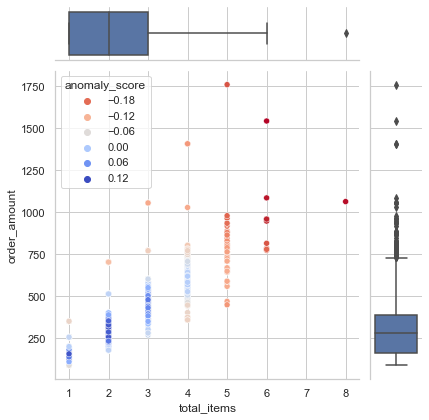

In [19]:
sns.set_style('whitegrid')
g = sns.JointGrid(x='total_items', y='order_amount',  data=df, hue ='anomaly_score')
g.plot_marginals(sns.boxplot)
g.plot_joint(sns.scatterplot, hue ='anomaly_score', palette="coolwarm_r" )

g.ax_joint.set_xlabel("total_items")
g.ax_joint.set_ylabel("order_amount")

In [20]:
df.sort_values(by=["anomaly_score"]).head(10)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,anomaly_score,item_price
691,692,78,878,1543.5,6,debit,2017-03-27 22:51:43,-0.233931,257.25
4141,4142,54,733,1064.0,8,debit,2017-03-07 17:05:18,-0.230566,133.00
3538,3539,43,830,1086.0,6,debit,2017-03-17 19:56:29,-0.227012,181.00
1563,1564,91,934,960.0,6,debit,2017-03-23 8:25:49,-0.223965,160.00
4847,4848,13,993,960.0,6,cash,2017-03-27 11:00:45,-0.223965,160.00
2307,2308,61,723,948.0,6,credit_card,2017-03-26 11:29:37,-0.222826,158.00
1364,1365,42,797,1760.0,5,cash,2017-03-10 6:28:21,-0.197606,352.00
3865,3866,68,815,816.0,6,debit,2017-03-11 9:31:50,-0.196037,136.00
3252,3253,67,706,786.0,6,credit_card,2017-03-29 16:05:41,-0.186722,131.00
3077,3078,89,754,980.0,5,debit,2017-03-13 5:27:58,-0.185482,196.00


It passes both inspections! The AOV becomes:

In [21]:
df["order_amount"].mean()

304.330323098535

# Question 2

For this question you’ll need to use SQL. Follow this link to access the data set required for the challenge. https://www.w3schools.com/SQL/TRYSQL.ASP?FILENAME=TRYSQL_SELECT_ALL
Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

How many orders were shipped by Speedy Express in total? **54**

What is the last name of the employee with the most orders? **Peacock**

What product was ordered the most by customers in Germany? **Boston Crab Meat**

``` mysql
SELECT COUNT(*)
FROM ORDERS as t1
JOIN SHIPPERS as t2
ON t1.shipperid = t2.shipperid
WHERE shippername="Speedy Express"
```

``` mysql
SELECT t1.employeeid, t2.lastname, COUNT(*) NumOrders
FROM ORDERS as t1
JOIN EMPLOYEES as t2
ON t1.employeeid = t2.employeeid
GROUP BY t1.employeeid
ORDER BY NumOrders DESC
```

``` mysql
SELECT productname, SUM(t3.quantity) TotalQuantities
FROM ORDERS as t1
JOIN CUSTOMERS as t2
ON t1.customerid = t2.customerid
JOIN ORDERDETAILS as t3
ON t1.orderid = t3.orderid
JOIN PRODUCTS as t4
ON t3.productid = t4.productid
WHERE country = "Germany"
GROUP BY t3.productid
ORDER BY TotalQuantities DESC
LIMIT 1
```